In [96]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg' # For mac users with Retina display

import sys
import numpy as np
import matplotlib.pyplot as plt
import sys, random
from cosmojo.universe import Cosmo
from cosmojo.utils import nl_cmb, bl
from scipy.integrate import simps
from astropy.io import fits
from astropy.visualization import hist
from astropy.wcs import WCS

sys.path.append('../FlatSpec/')
from Spec2D import *
from Sims import *

from XCroutines import file2array, GetHATLASCountsMap, GetHATLASDeltaMaps

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
def CreateMask(cnt, sigma=1., smooth=False):
    mask = np.ones(cnt.shape)
    mask[ndimage.gaussian_filter(cnt, sigma=sigma) == 0] = 0.
    if smooth:
        return smooth_window(mask)
    else:
        return mask

# CIB maps from Blake

In [3]:
ra12, h12 = fits.getdata('finalra12500JySrF.fits', header=True)
ra23, h23 = fits.getdata('finalra23500JySrF.fits', header=True)
wcs12 = WCS(h12)
wcs23 = WCS(h23)

In [160]:
h12, h23

(SIMPLE  =                    T / conforms to FITS standard                      
 BITPIX  =                  -64 / array data type                                
 NAXIS   =                    2 / number of array dimensions                     
 NAXIS1  =                  271                                                  
 NAXIS2  =                  271                                                  
 CTYPE1  = 'RA---CEA'                                                            
 CTYPE2  = 'DEC--CEA'                                                            
 CRVAL1  =    180.0166666666667                                                  
 CRVAL2  = -0.01666666666666667                                                  
 CRPIX1  =                136.5                                                  
 CRPIX2  =                136.5                                                  
 CDELT1  = -0.03333333333333333                                                  
 CDELT2  =  0.03

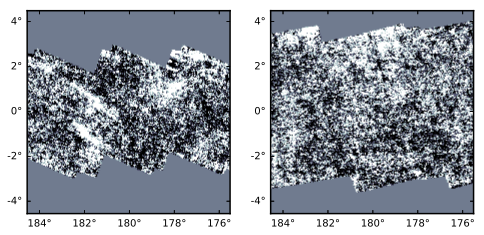

In [4]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection=wcs12)
ax1.imshow(ra12, vmin=-1e5, vmax=1e5, origin='lower', cmap='bone')
ax2 = fig.add_subplot(122, projection=wcs23)
ax2.imshow(ra23, vmin=-1e5, vmax=1e5, origin='lower', cmap='bone')


Note that
i) They have the same WCS (which is wrong)
ii) they are oriented in the astrophysics way, i.e. RA is *decreasing* toward right instead of increasing


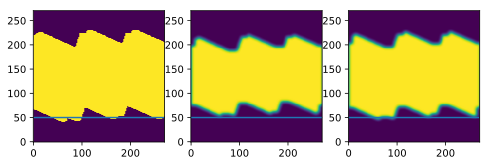

In [167]:
plt.figure(figsize=(8,6))
plt.subplot(131)
plt.imshow(CreateMask(ra12), origin='lower')
plt.axhline(50)
plt.subplot(132)
plt.imshow(CreateMask(ra12, sigma=1, smooth=True), origin='lower')
plt.axhline(50)
plt.subplot(133)
plt.imshow(CreateMask(ra12, sigma=2, smooth=True), origin='lower')
plt.axhline(50)

In [132]:
RA12 = FlatMapReal(271, 2, np.fliplr(ra12), mask=CreateMask(np.fliplr(ra12), sigma=1, smooth=1))
RA23 = FlatMapReal(271, 2, np.fliplr(ra23), mask=CreateMask(np.fliplr(ra23), sigma=1, smooth=1))

In [133]:
FT_RA12 = FlatMapFFT(271, 2, map=RA12)
FT_RA23 = FlatMapFFT(271, 2, map=RA23)

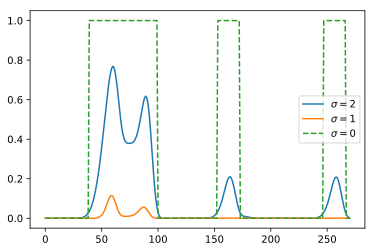

In [9]:
plt.plot(CreateMask(ra12, sigma=2, smooth=True)[50,:], label=r'$\sigma=2$')
plt.plot(CreateMask(ra12, smooth=True)[50,:], label=r'$\sigma=1$')
plt.plot(CreateMask(ra12, smooth=0)[50,:], '--', label=r'$\sigma=0$')
plt.legend()

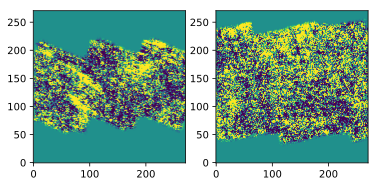

In [45]:
plt.subplot(121)
plt.imshow(ra12*CreateMask(ra12, sigma=1, smooth=1), vmin=-1e5, vmax=1e5, origin='lower')
plt.subplot(122)
plt.imshow(ra23*CreateMask(ra23, sigma=1, smooth=1), vmin=-1e5, vmax=1e5, origin='lower')

In [149]:
l, cl = FT_RA12.GetCl()
l1, cl1 = FT_RA23.GetCl()#(lbins=np.linspace(0,8000,20))

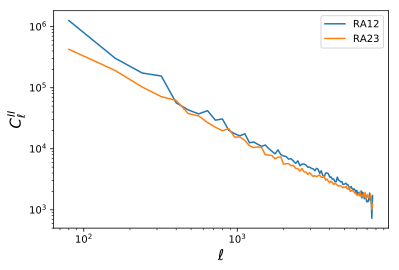

In [154]:
plt.loglog(l, cl, label='RA12')
plt.loglog(l1, cl1, label='RA23')
plt.legend()
plt.xlabel(r'$\ell$', size=15)
plt.ylabel(r'$C_{\ell}^{II}$', size=15)


# Herschel-ATLAS count maps

In [76]:
ra12_counts = GetHATLASCountsMap('RA12')
ra23_counts = GetHATLASCountsMap('RA23')

/Users/fbianchini/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/Users/fbianchini/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10


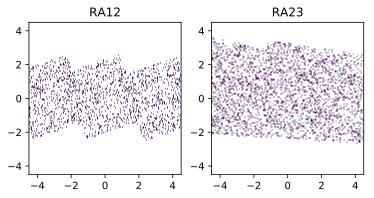

In [77]:
plt.subplot(121)
plt.title('RA12')
plt.imshow(np.log10(ra12_counts), origin='lower', extent=[-4.5,4.5,-4.5,4.5])#, vmin=-30, vmax=0, cmap='jet')
plt.subplot(122)
plt.title('RA23')
plt.imshow(np.log10(ra23_counts), origin='lower', extent=[-4.5,4.5,-4.5,4.5])#, vmin=-30, vmax=0)


/Users/fbianchini/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10
/Users/fbianchini/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10
/Users/fbianchini/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log10
/Users/fbianchini/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/Users/fbianchini/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10
/Users/fbianchini/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in log10


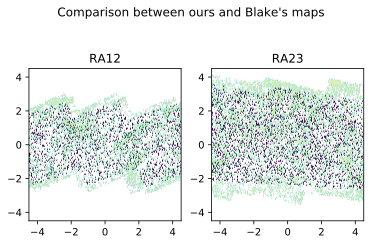

In [156]:
plt.suptitle('Comparison between ours and Blake\'s maps')
plt.subplot(121)
plt.title('RA12')
plt.imshow(np.log10(ra12_counts), origin='lower', extent=[-4.5,4.5,-4.5,4.5])#, vmin=-30, vmax=0, cmap='jet')
plt.imshow(np.log10(np.fliplr(ra12)), origin='lower', extent=[-4.5,4.5,-4.5,4.5], alpha=0.6)#, vmin=-30, vmax=0, cmap='jet')
plt.subplot(122)
plt.title('RA23')
plt.imshow(np.log10(ra23_counts), origin='lower', extent=[-4.5,4.5,-4.5,4.5])#, vmin=-30, vmax=0, cmap='jet')
plt.imshow(np.log10(np.fliplr(ra23)), origin='lower', extent=[-4.5,4.5,-4.5,4.5], alpha=0.6)#, vmin=-30, vmax=0, cmap='jet')


# Herschel-ATLAS density maps

In [103]:
ra12_delta = GetHATLASDeltaMaps('RA12', pad_factor=1)
ra23_delta = GetHATLASDeltaMaps('RA23', pad_factor=1)

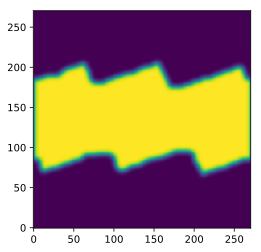

In [108]:
plt.imshow(ra12_delta.mask, origin='lower')

In [172]:
L12, CL_12_gg = FlatMapFFT(271, 2, map=ra12_delta).GetCl()
L23, CL_23_gg = FlatMapFFT(271, 2, map=ra23_delta).GetCl()
# L12, CL_12_gg = FlatMapFFT(271*2, 2, map=ra12_delta.Pad(2)).GetCl()
# L23, CL_23_gg = FlatMapFFT(271*2, 2, map=ra23_delta.Pad(2)).GetCl()

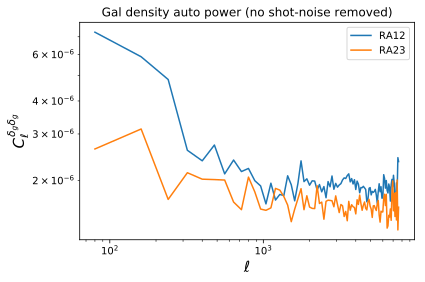

In [169]:
plt.title('Gal density auto power (no shot-noise removed)')
plt.loglog(L12, CL_12_gg, label='RA12')
plt.loglog(L23, CL_23_gg, label='RA23')
plt.legend()
plt.xlabel(r'$\ell$', size=15)
plt.ylabel(r'$C_{\ell}^{\delta_g\delta_g}$', size=15)

In [134]:
L_12, CL_12 = FT_RA12.GetCl(map2=ra12_delta)
L_23, CL_23 = FT_RA23.GetCl(map2=ra23_delta)

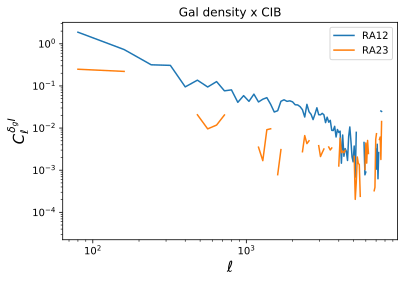

In [157]:
plt.title('Gal density x CIB')
plt.loglog(L_12, CL_12, label='RA12')
plt.loglog(L_23, CL_23, label='RA23')
plt.legend()
plt.xlabel(r'$\ell$', size=15)
plt.ylabel(r'$C_{\ell}^{\delta_g I}$', size=15)

 # PB masks

In [66]:
pb_ra12_mask = file2array('pb_P_mask_pb1ra12hab_3x3.txt').real
pb_ra23_mask = file2array('pb_P_mask_pb1ra23hab_3x3.txt').real
ps_ra12_mask = file2array('psRA12.txt').real
ps_ra23_mask = file2array('psRA23.txt').real
pb_ra12_mask_tot = pb_ra12_mask * ps_ra12_mask
pb_ra23_mask_tot = pb_ra23_mask * ps_ra23_mask

/Users/fbianchini/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/Users/fbianchini/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10


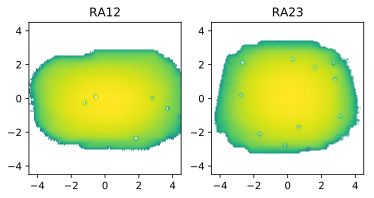

In [70]:
plt.subplot(121)
plt.title('RA12')
plt.imshow(np.log10(pb_ra12_mask_tot/pb_ra12_mask_tot.max()), origin='lower', extent=[-4.5,4.5,-4.5,4.5])#, vmin=-30, vmax=0, cmap='jet')
plt.subplot(122)
plt.title('RA23')
plt.imshow(np.log10(pb_ra23_mask_tot/pb_ra23_mask_tot.max()), origin='lower', extent=[-4.5,4.5,-4.5,4.5])#, vmin=-30, vmax=0)


# Test on Simulated maps

I create a map with $C_{\ell} \propto \ell^{-2}$

In [31]:
M = GenCorrFlatMaps(np.nan_to_num(1./np.arange(1,10000))**2, 271, 2, buff=2)

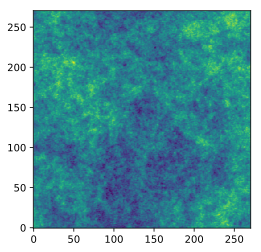

In [148]:
plt.imshow(M, origin='lower')

In [35]:
FT = FlatMapFFT(271, 2, map=FlatMapReal(271, 2, map=M, mask=CreateMask(ra12, sigma=1, smooth=1)))
FT_pad = FlatMapFFT(271*2, 2, map=FlatMapReal(271, 2, map=M, mask=CreateMask(ra12, sigma=1, smooth=1)).Pad(2))
FT_nomask = FlatMapFFT(271, 2, map=FlatMapReal(271, 2, map=M))

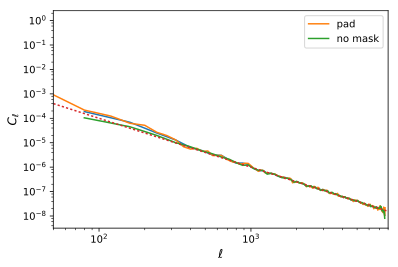

In [59]:
plt.loglog(FT.GetCl()[0], FT.GetCl()[1])
plt.loglog(FT_pad.GetCl()[0], FT_pad.GetCl()[1], label='pad')
plt.loglog(FT_nomask.GetCl()[0], FT_nomask.GetCl()[1], label='no mask')
plt.loglog(np.arange(1,10000), np.nan_to_num(1./np.arange(1,10000))**2, ':')
plt.legend()
plt.xlim([50,8000])
plt.xlabel(r'$\ell$', size=12)
plt.ylabel(r'$C_{\ell}$', size=12)

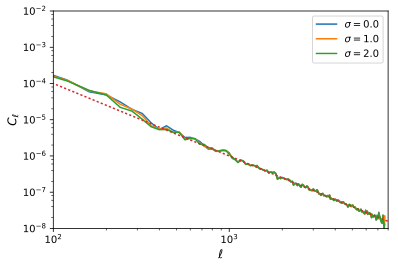

In [60]:
for sigma in [0, 1, 2,]:#[0, 0.5, 1, 1.5, 2., 2.5, 3.]:
    FT_sigma = FlatMapFFT(271*2, 2, map=FlatMapReal(271, 2, map=M, mask=CreateMask(ra12, sigma=sigma, smooth=1)).Pad(2))
    plt.loglog(FT_sigma.GetCl()[0], FT_sigma.GetCl()[1], label=r'$\sigma=%.1f$'%sigma )
plt.loglog(np.arange(1,10000), np.nan_to_num(1./np.arange(1,10000))**2, ':')
plt.legend()
plt.xlim([100,8000])
plt.ylim([1e-8,1e-2])
plt.xlabel(r'$\ell$', size=12)
plt.ylabel(r'$C_{\ell}$', size=12)